### SAM index and persistence calculation using ERA5 daily geopotential at 500 hPa
Author : Ting-Chen Chen (ting-chen.chen@uclouvain.be)

Following the method of 

Simpson, I.R., Hitchcock, P., Shepherd, T.G., Scinocca, J.F., 2013a. Southern Annular Mode Dynamics in Observations and Models. Part I: The Influence of Climatological Zonal Wind Biases in a Comprehensive GCM. J. Clim. 26, 3953–3967. https://doi.org/10.1175/JCLI-D-12-00348.1

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import os,sys
from datetime import datetime
from scipy.signal import detrend

import warnings
warnings.filterwarnings("ignore")

### Read in the ERA5 file

In [4]:
#ds= xr.open_dataset("saved_on_disk.nc")
indir='/work/bk1377/b382037/WP7/ERA5/'

#for year in range(1940,1950):
#    inputfile = indir+'ERA5_500hPa_geop_1D_'+str(year)+'_regular.nc'
#    ds= xr.open_mfdataset(inputfile)

ds= xr.open_mfdataset(''+indir+'ERA5_500hPa_geop_1D_*_regular.nc', concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')

In [5]:
ds['time'] = pd.to_datetime(ds['time'].values, format='%Y%m%d')

In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 30681, lon: 1280, lat: 640, plev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-12-31
  * lon      (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... 89.02 89.3 89.58 89.86
  * plev     (plev) float64 5e+04
Data variables:
    geop     (time, plev, lat, lon) float32 dask.array<chunksize=(366, 1, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Jun 11 18:14:23 2024: cdo -mergetime ERA5_500hPa_geop_1...
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

In [7]:
ds =ds.sel(time=slice("1980-01-01","2023-12-31"))
#ds =ds.sel(time=slice("1958-01-01","1978-12-31"))

### First step: obtain the daily zonal mean geopotential height at 500 hPa

In [8]:
# Do zonal averaging first
zbar = ds.squeeze(dim='plev').mean(dim="lon", skipna=True)

In [9]:
zbar

<xarray.Dataset>
Dimensions:  (time: 16071, lat: 640)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
  * lat      (lat) float64 -89.86 -89.58 -89.3 -89.02 ... 89.02 89.3 89.58 89.86
    plev     float64 5e+04
Data variables:
    geop     (time, lat) float32 dask.array<chunksize=(366, 640), meta=np.ndarray>

### Second step: remove the global mean geopotential on daily basis

In [10]:
# Calculate global mean
z_globe = zbar.mean(dim="lat", skipna=True)
print(z_globe)
daily_value = zbar - z_globe

<xarray.Dataset>
Dimensions:  (time: 16071)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31
    plev     float64 5e+04
Data variables:
    geop     (time) float32 dask.array<chunksize=(366,), meta=np.ndarray>


### Second and an half step: detrend (remove a linear trend)

In [11]:
detrended = detrend(daily_value['geop'], axis=0, type='linear')
detrended

array([[  903.4419 ,   901.6841 ,   897.8174 , ...,  -197.75562,
         -193.85864,  -191.9187 ],
       [  852.0464 ,   849.7534 ,   845.1133 , ...,  -634.25586,
         -631.1245 ,  -629.4463 ],
       [ 1091.3345 ,  1092.3892 ,  1093.6245 , ..., -1894.6426 ,
        -1894.0034 , -1893.7002 ],
       ...,
       [  749.7197 ,   750.4165 ,   751.271  , ...,   761.8789 ,
          756.7566 ,   753.8584 ],
       [ 1028.1641 ,  1029.0835 ,  1029.3013 , ...,   328.27344,
          327.4751 ,   326.7295 ],
       [ 1354.21   ,  1353.5986 ,  1351.9023 , ...,  -486.79712,
         -487.6421 ,  -488.7705 ]], dtype=float32)

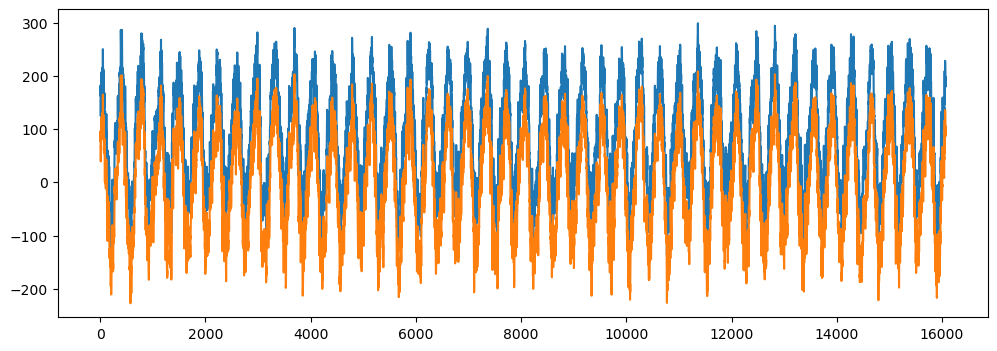

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(daily_value['geop'].isel(lat=172)/9.81)
#plt.plot(x_filt[:,194])
plt.plot(detrended[:,172]/9.81)

### Third step: remove a slowly varying climatology (to remove the seasonal cycle and the low-frequency nonlinear trends associated with known external forcings such as the ozone hole formation/recovery and global warming signal)

Calculate the slowly varying trend climatology and the "noise".
Based on Gerber et al. (2010):
1. first apply a 60 day low pass filter to the daily zonal mean geopotential (here called "gmsp_60d")
2. For each date and location, apply a 30 year low pass filter to the smoothed time series, using only that calendar date of each year in the data set (Zbar_t)
3. The internal variability is the "noise": Zbar_i = Zbar - Zbar_t  

#### 1. first apply a 60 day low pass filter to the daily zonal mean geopotential (here called "gmsp_60d")

In [13]:
x=detrended
print(x.shape)

(16071, 640)


In [14]:
from scipy.fftpack import rfft, irfft, fftfreq, fft
nt=x.shape[0]

t=np.arange(0, nt)
print(t.shape)

xf=fft(x, axis=0)

f_signal = rfft(x, axis=0)
w = fftfreq(x.shape[0], d=t[1]-t[0])

cut_f_signal = f_signal.copy()
cut_f_signal[(np.abs(w)>1/60)] = 0 
cut_signal = irfft(cut_f_signal, axis=0) 

(16071,)


In [15]:
print(cut_signal.shape)

(16071, 640)


In [16]:
difference_array = np.absolute(daily_value.lat-(-41.5))
 
# find the index of minimum element from the array
index = difference_array.argmin()
print(index.values)

172


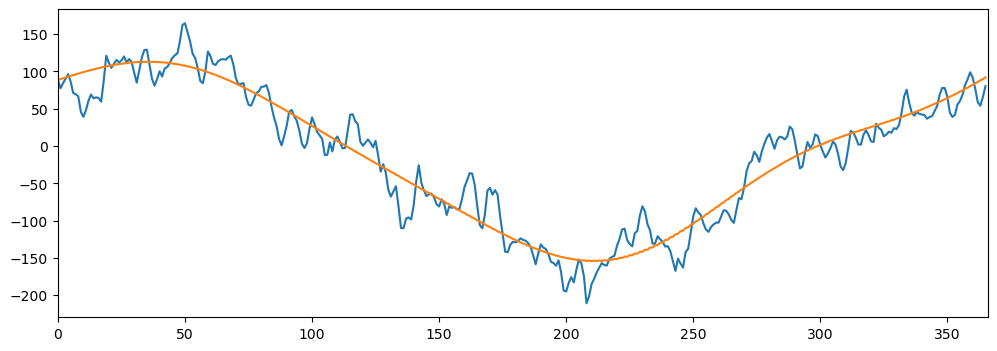

In [17]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x[0:366,index]/9.81)
plt.xlim(0,366)
#plt.plot(x_filt[:,194])
plt.plot(cut_signal[0:366,index]/9.81)

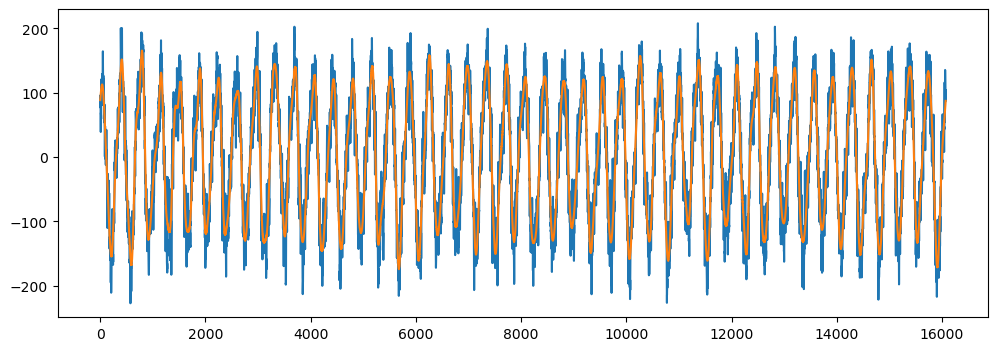

In [18]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x[:,index]/9.81)
#plt.plot(x_filt[:,194])
plt.plot(cut_signal[:,index]/9.81)

In [19]:
daily_value["geop_detrended"]=(['time', 'lat'],  detrended.astype(float))
daily_value["geop_detrended_60d"]=(['time', 'lat'],  cut_signal.astype(float))

In [20]:
daily_value

<xarray.Dataset>
Dimensions:             (time: 16071, lat: 640)
Coordinates:
  * time                (time) datetime64[ns] 1980-01-01 ... 2023-12-31
  * lat                 (lat) float64 -89.86 -89.58 -89.3 ... 89.3 89.58 89.86
    plev                float64 5e+04
Data variables:
    geop                (time, lat) float32 dask.array<chunksize=(366, 640), meta=np.ndarray>
    geop_detrended      (time, lat) float64 903.4 901.7 897.8 ... -487.6 -488.8
    geop_detrended_60d  (time, lat) float64 1.288e+03 1.289e+03 ... -685.4

### 2. For each date and location, apply a 30 year low pass filter to the smoothed time series, using only that calendar date of each year in the data set (Zbar_t)

In [21]:

def func(group):
    
    x=group.to_numpy()
    nt=x.shape[0]
    #print(nt)
    t=np.arange(0, nt)
    xf=fft(x, axis=0)
    f_signal = rfft(x, axis=0)
    w = fftfreq(x.shape[0], d=t[1]-t[0])

    cut_f_signal = f_signal.copy()
    cut_f_signal[(np.abs(w)>1/30)] = 0 
    cut_signal = irfft(cut_f_signal, axis=0)

    group["geop_detrended_30y"]=(['time', 'lat'],  cut_signal.astype(float))

    return group["geop_detrended_30y"]


clim_test= daily_value["geop_detrended_60d"].groupby("time.dayofyear").apply(func)

======= Just for comparison (the all-year average) ============================================

In [22]:
clim_test2= daily_value["geop_detrended_60d"].groupby("time.dayofyear").mean("time")

===============================================================================

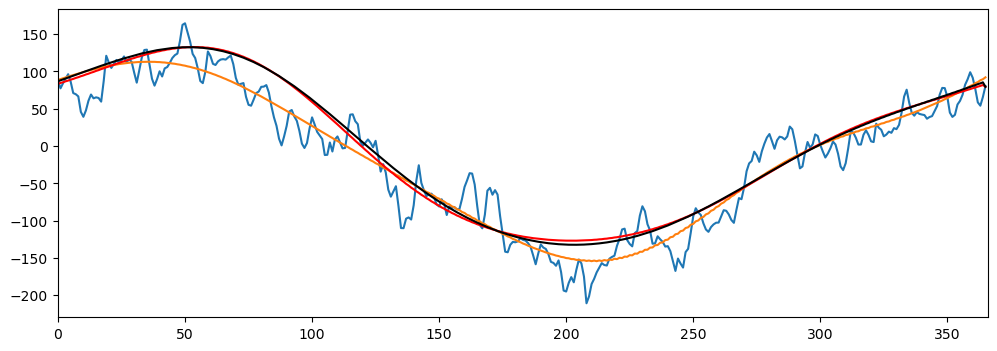

In [23]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(x[0:366,index]/9.81)
plt.xlim(0,366)
#plt.plot(x_filt[:,194])
plt.plot(cut_signal[0:366,index]/9.81)
plt.plot(clim_test[0:366,index]/9.81,color='r')
plt.plot(clim_test2[0:366,index]/9.81,color='k')

### 3. The internal variability is the "noise": Zbar_i = Zbar - Zbar_t  

In [24]:
anom_final= daily_value["geop_detrended"]-clim_test["geop_detrended_30y"]

In [25]:
anom_final

<xarray.DataArray (time: 16071, lat: 640)>
array([[ -741.16371048,  -743.50118098,  -747.91466148, ...,
          586.57646318,   589.2781203 ,   590.63030338],
       [ -791.07026708,  -793.99952895,  -799.30097533, ...,
          151.17006485,   153.38733042,   154.62653601],
       [ -558.50227491,  -558.04766855,  -557.40223474, ...,
        -1096.8468648 , -1097.3670245 , -1097.63434643],
       ...,
       [ -883.26638842,  -883.16679262,  -882.88294525, ...,
         1527.25468144,  1520.87175821,  1517.3638113 ],
       [ -613.65810291,  -613.35305041,  -613.74578112, ...,
         1097.62390065,  1095.61486528,  1094.27460094],
       [ -290.78312695,  -292.02088461,  -294.3456158 , ...,
          290.9795549 ,   288.94024596,   287.235845  ]])
Coordinates:
  * time                (time) datetime64[ns] 1980-01-01 ... 2023-12-31
  * lat                 (lat) float64 -89.86 -89.58 -89.3 ... 89.3 89.58 89.86
    plev                float64 5e+04
    geop_detrended_30y  (time, lat) float64 1.645e+03 1.645e+03 ... -776.0

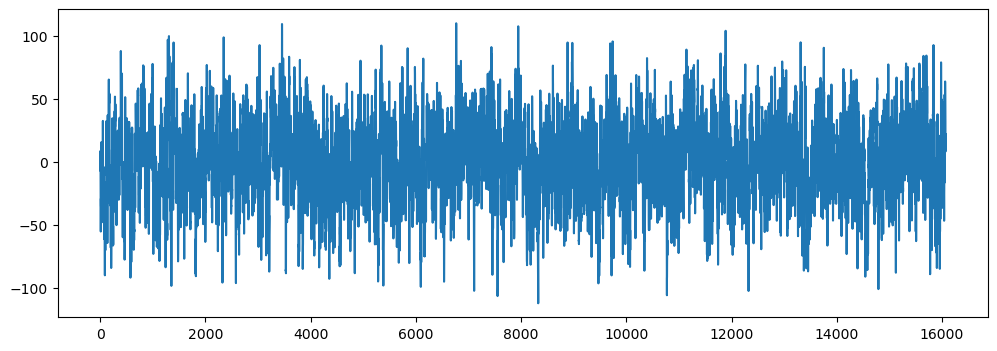

In [26]:
import matplotlib.pyplot as plt
shift=12000
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(anom_final[:,index]/9.81)
#plt.xlim(0+shift,366+shift)
#plt.plot(x_filt[:,194])

### Compute the leading EOF for the region south of 20°S

In [27]:
from eofs.standard import Eof
from eofs.examples import example_data_path

In [28]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.

z = anom_final.sel(lat=slice(-89.9,-20))


In [29]:
z

<xarray.DataArray (time: 16071, lat: 249)>
array([[-741.16371048, -743.50118098, -747.91466148, ...,   13.1478982 ,
          12.74826918,   12.29063866],
       [-791.07026708, -793.99952895, -799.30097533, ...,   27.82086293,
          27.52242615,   27.08633927],
       [-558.50227491, -558.04766855, -557.40223474, ...,   38.85648067,
          39.02628115,   39.21887615],
       ...,
       [-883.26638842, -883.16679262, -882.88294525, ...,  206.92185055,
         210.64026626,  214.32131942],
       [-613.65810291, -613.35305041, -613.74578112, ...,  226.14839001,
         229.80743346,  233.30944643],
       [-290.78312695, -292.02088461, -294.3456158 , ...,  224.33402353,
         228.0200091 ,  231.88613947]])
Coordinates:
  * time                (time) datetime64[ns] 1980-01-01 ... 2023-12-31
  * lat                 (lat) float64 -89.86 -89.58 -89.3 ... -20.39 -20.11
    plev                float64 5e+04
    geop_detrended_30y  (time, lat) float64 1.645e+03 1.645e+03 ... 258.5 250.6

In [30]:
z.coords['lat'].values

array([-89.859     , -89.57775117, -89.29650235, -89.01525352,
       -88.73400469, -88.45275587, -88.17150704, -87.89025822,
       -87.60900939, -87.32776056, -87.04651174, -86.76526291,
       -86.48401408, -86.20276526, -85.92151643, -85.64026761,
       -85.35901878, -85.07776995, -84.79652113, -84.5152723 ,
       -84.23402347, -83.95277465, -83.67152582, -83.390277  ,
       -83.10902817, -82.82777934, -82.54653052, -82.26528169,
       -81.98403286, -81.70278404, -81.42153521, -81.14028638,
       -80.85903756, -80.57778873, -80.29653991, -80.01529108,
       -79.73404225, -79.45279343, -79.1715446 , -78.89029577,
       -78.60904695, -78.32779812, -78.0465493 , -77.76530047,
       -77.48405164, -77.20280282, -76.92155399, -76.64030516,
       -76.35905634, -76.07780751, -75.79655869, -75.51530986,
       -75.23406103, -74.95281221, -74.67156338, -74.39031455,
       -74.10906573, -73.8278169 , -73.54656808, -73.26531925,
       -72.98407042, -72.7028216 , -72.42157277, -72.14

In [31]:
znumpy=z.to_numpy()

In [32]:
znumpy.shape

(16071, 249)

In [33]:
coslat = np.cos(np.deg2rad(z.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(znumpy, weights=wgts)
#solver = Eof(znumpy)

In [34]:
eof1 = solver.eofs(neofs=1)
pc1   = solver.pcs(npcs=1) 
pc1_rescaled  = solver.pcs(npcs=1, pcscaling=1) # this is the normalized PC1 (divided by variance)
eof1_rescaled = solver.eofs(neofs=1, eofscaling=2) # this is the rescaled eof1 (multiplied by variance)
variance_fractions = solver.varianceFraction(neigs=1)

In [35]:
print(variance_fractions)

[0.70412535]


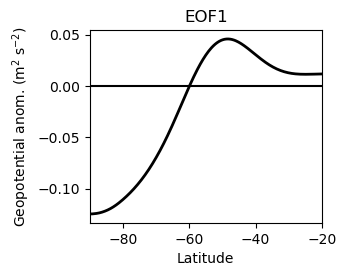

In [36]:
plt.figure(figsize=(3,2.5))
plt.plot(z.coords['lat'].values, eof1[0,:]*-1,color='k', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(-90, -20)
ax.set_xlabel('Latitude')
ax.set_ylabel('Geopotential anom. ' r'$(\mathrm{m}^{2}$'' 'r'$\mathrm{s}^{-2})$')
ax.set_title('EOF1', fontsize=12)
#plt.text(0.95, 0.1, ''+str('{:4.1f}'.format(variance_fractions.item(0)*100))+' %' , fontsize=12, horizontalalignment='right',
#     verticalalignment='center', transform=ax.transAxes, color='b', weight='bold')

#plt.savefig('EOF1_500hPageopo_ERA5_1958-1978', bbox_inches='tight', dpi=100)
plt.show()

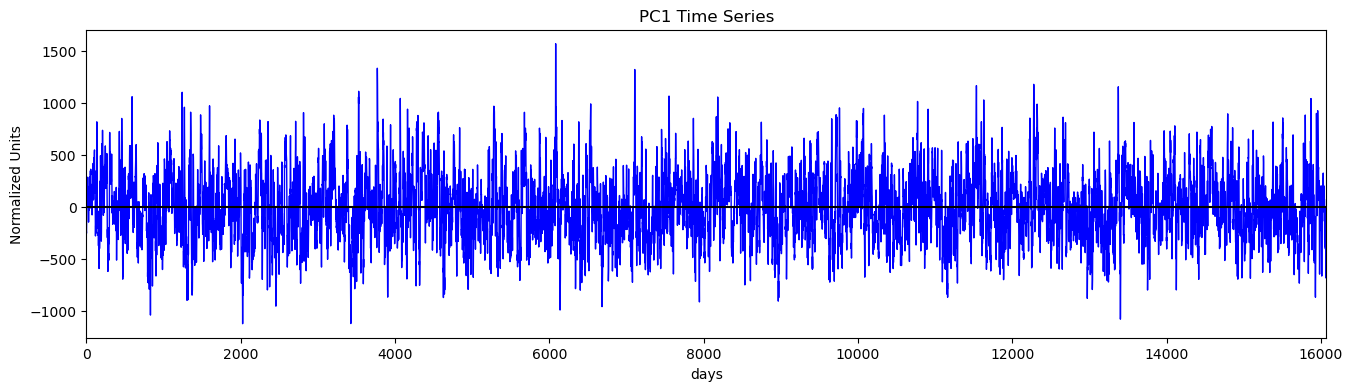

In [37]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(16,4))
plt.plot(pc1[:, 0],color='b', linewidth=1)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(0,nt)
ax.set_xlabel('days')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=12)

plt.savefig('PC1_500hPageoheight_ERA5', bbox_inches='tight', dpi=100)

plt.show()

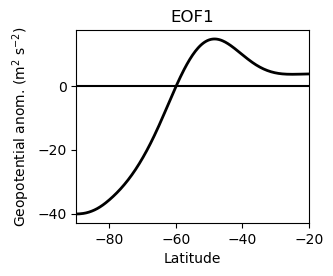

In [38]:
plt.figure(figsize=(3,2.5))
plt.plot(z.coords['lat'].values, eof1_rescaled[0,:]*-1,color='k', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(-90, -20)
ax.set_xlabel('Latitude')
ax.set_ylabel('Geopotential anom. ' r'$(\mathrm{m}^{2}$'' 'r'$\mathrm{s}^{-2})$')
ax.set_title('EOF1', fontsize=12)
#plt.text(0.95, 0.1, ''+str('{:4.1f}'.format(variance_fractions.item(0)*100))+' %' , fontsize=12, horizontalalignment='right',
#     verticalalignment='center', transform=ax.transAxes, color='b', weight='bold')

#plt.savefig('EOF1_500hPageopo_ERA5_1958-1978', bbox_inches='tight', dpi=100)
plt.show()

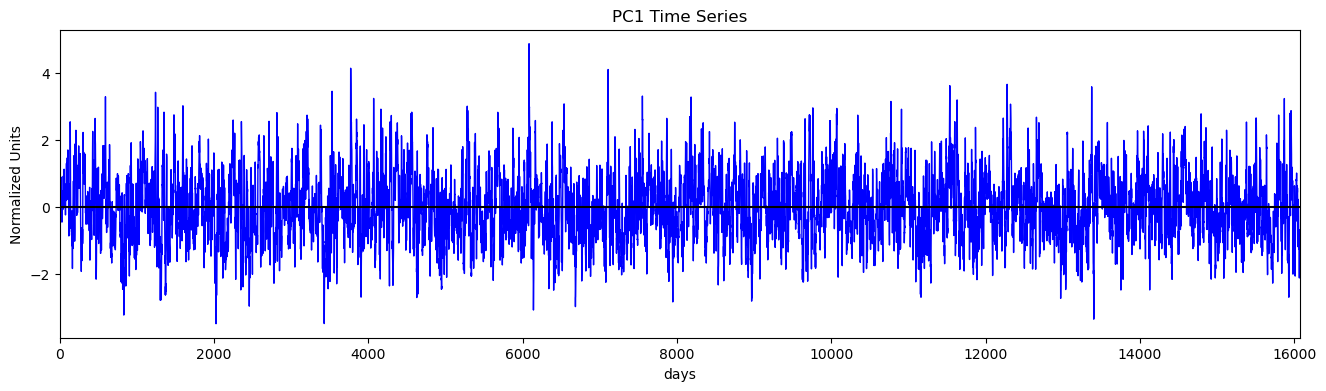

In [39]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(16,4))
plt.plot(pc1_rescaled[:, 0],color='b', linewidth=1)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(0,nt)
ax.set_xlabel('days')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=12)

#plt.savefig('PC1_500hPageoheight_ERA5', bbox_inches='tight', dpi=100)

plt.show()

### Magnitude of EOF, |e|, which equals the square root of the sum of e_i*e_i, where e_i is the EOF e at the i-th latitude.

In [40]:
ny=eof1_rescaled[0,:].shape[0]

In [41]:
AvgEOF = 0 
for j in range(0, ny):
    AvgEOF = AvgEOF+eof1_rescaled[0,j]*eof1_rescaled[0,j]
print(np.sqrt(AvgEOF), np.sqrt(AvgEOF/ny))

322.2107225308728 20.419274864682787


In [42]:
#EXPname='ERA5_1958_1978'
EXPname='ERA5_1980_2023'

#with open(EXPname+"_EOFmagnitude.txt", "w") as file:
#    print(np.sqrt(AvgEOF/ny), file=file)

### Calculate the e-folding timescale 

The diagnostic used is the decorrelation timescale, which is the e‐folding timescale of the autocorrelation function of the SAM index. 
1. take a 180 day window around a given day, smoothing it with a Gaussian filter with a full width at half maximum (FWHM) of 60 days
2. calculate the autocorrelation of above smoothened SAM index

In [43]:
pc1_ar= pc1_rescaled.squeeze()*-1

In [44]:
pc1.shape

(16071, 1)

In [45]:
pc1_ar.shape

(16071,)

In [46]:
pc1_ar.reshape((-1, 1))

array([[0.74962582],
       [0.79176988],
       [0.56287688],
       ...,
       [1.13137111],
       [0.99593561],
       [0.87652998]])

In [47]:
znumpy.shape

(16071, 249)

In [48]:
znumpy_weighted= znumpy*coslat

In [49]:
znumpy_weighted.shape

(16071, 249)

In [50]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

SAM_struc = np.zeros(249)

model.fit(pc1_ar.reshape(-1, 1), znumpy_weighted) #pc1_ar.reshape((-1, 1)), #model.fit(x,y)
#model.fit(pc1_ar, znumpy_weighted)
print(f"intercept: {model.intercept_.shape}")
#print(f"slope: {model.coef_}")
#SAM_pattern = model.predict()
#print(SAM_pattern.shape)
#lt.figure()
#plt.plot(z.coords['lat'].values, model.intercept_,color='b', linewidth=2)

intercept: (249,)


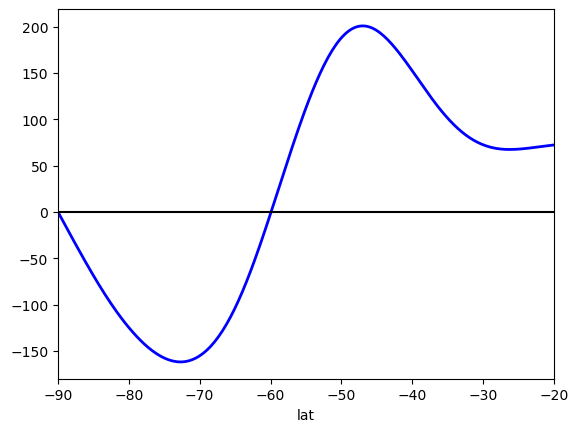

In [51]:
plt.figure()
plt.plot(z.coords['lat'].values, model.coef_ ,color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_xlim(-90, -20)
ax.set_xlabel('lat')
#ax.set_ylabel('meters')
#ax.set_title('EOF1', fontsize=12)
#plt.text(0.95, 0.1, ''+str('{:4.1f}'.format(variance_fractions.item(0)*100))+' %' , fontsize=12, horizontalalignment='right',
#     verticalalignment='center', transform=ax.transAxes, color='b', weight='bold')

#plt.savefig('EOF1_500hPageoheight_ERA5', bbox_inches='tight', dpi=100)
plt.show()

### Extracting the PC1 time series in preparation for the autocorrelation fuction (ACF) 

In [52]:
coords= {'time':daily_value["geop"].coords['time'],}
SAM_window    = xr.DataArray(np.full((51,nt),fill_value=np.nan), dims=["lags","time"], coords= coords)

for i in range(0, nt-51):  # Adjust indices to account for slicing

       # Extract the 180-day window around the current day
        window_data = pc1_ar[i:i+51]    
        SAM_window.isel(time=i).values[:]    = window_data

In [53]:
SAM_window_noleap=SAM_window.convert_calendar('noleap')

In [54]:
SAM_window_noleap

<xarray.DataArray (lags: 51, time: 16060)>
array([[ 0.74962582,  0.79176988,  0.56287688, ...,         nan,
                nan,         nan],
       [ 0.79176988,  0.56287688,  0.26893536, ...,         nan,
                nan,         nan],
       [ 0.56287688,  0.26893536,  0.07485465, ...,         nan,
                nan,         nan],
       ...,
       [-0.47979095, -0.41711214, -0.3070931 , ...,         nan,
                nan,         nan],
       [-0.41711214, -0.3070931 , -0.62526675, ...,         nan,
                nan,         nan],
       [-0.3070931 , -0.62526675, -1.0756484 , ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2023-12-31 00:00:00
Dimensions without coordinates: lags

In [55]:
mean_SAM = SAM_window_noleap.groupby("time.dayofyear").mean("time")

In [56]:
mean_SAM

<xarray.DataArray (lags: 51, dayofyear: 365)>
array([[ 0.01373925,  0.00784786,  0.05558078, ...,  0.05413343,
         0.03105238,  0.0615275 ],
       [ 0.00784786,  0.05558078,  0.04081868, ...,  0.03105238,
         0.0615275 , -0.0033744 ],
       [ 0.05558078,  0.04081868,  0.04781945, ...,  0.0615275 ,
        -0.0033744 , -0.01038289],
       ...,
       [ 0.10091315,  0.0438868 ,  0.02874338, ...,  0.20396748,
         0.14485678,  0.12765913],
       [ 0.0438868 ,  0.02874338, -0.00450551, ...,  0.14485678,
         0.12765913,  0.1144179 ],
       [ 0.02874338, -0.00450551, -0.05851398, ...,  0.12765913,
         0.1144179 ,  0.0546077 ]])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: lags

In [57]:
mean_SAM_np = mean_SAM.to_numpy()
SAM_window_noleap_np = SAM_window_noleap.to_numpy()

In [58]:
SAM_window_noleap_np.shape

(51, 16060)

In [59]:
print(SAM_window_noleap_np[0,0])

0.7496258207984022


In [60]:
from scipy.ndimage import filters
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt   
from scipy.ndimage import gaussian_filter

In [61]:
import math 
coords= {'time':SAM_window_noleap.isel(time=slice(0,365)).coords['time'],}

ACF_ens = xr.DataArray(np.full((51,365),fill_value=np.nan), dims=["lags","time"], coords= coords)
total_years = int(nt/365) #16425/365=45

for days in range(0,365):
    for lags in range(51): 
        numerator = 0.
        denominatorA = 0.
        denominatorB = 0.
        for yy in range(total_years):

            if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
                numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])*(SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])
                denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])**2
                denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])**2  
            #if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
            #    numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy])*(SAM_window_noleap_np[0+lags,days+365*yy])
            #    denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy])**2
            #    denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy])**2      
            #else:
            #    print('NAN found at days:',days,'year=',yy)
         
        ACF_ens[lags, days] = numerator/((denominatorA*denominatorB)**0.5) 
        

In [62]:
ACF_ens_3year = xr.concat([ACF_ens,ACF_ens,ACF_ens],"time")

In [63]:
ACF_ens_smooth = gaussian_filter(ACF_ens_3year, sigma=18, axes=1)

In [64]:
ACF_ens_smooth.shape

(51, 1095)

In [65]:
ACF_ens_smooth = ACF_ens_smooth[:,365:365+365]

In [66]:
ACF_ens_smooth.shape

(51, 365)

7.347731300956099


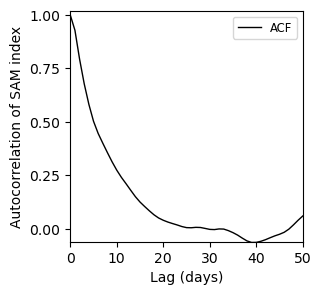

In [67]:
# Define the model function
def model_func(x, a, k):
    return a * np.exp(-k * x)
    
def model_func_re(y, a, k):
    return -1/k * np.log(y / a)

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(3,3))
ax = plt.gca()
inputx = np.arange(0, 51, dtype=float)
inputy = ACF_ens_smooth[:,50]
popt, pcov = curve_fit(model_func, inputx, inputy)
# Generate points for the fitted curve
#x_fit = np.linspace(0, 5, 100)
y_fit = model_func(inputx, *popt)
efoldtime = model_func_re(1/math.e,*popt)
print(efoldtime)
# x-value for plotting

#plot series
#plt.axhline(0)
#plt.axvline(0)

#plot series
#plt.axhline(1/math.e, xmin=0, xmax=efoldtime, c='crimson',lw=0.8,linestyle='dotted')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Autocorrelation of SAM index')
#for ens in range(40):
#plt.plot(ACF_ens_bootstrap_smooth[:,50,0], lw=0.8, color='0.5', label='ACF (bootstrap n)')
#    plt.plot(ACF_ens_bootstrap_smooth[:,50,ens], lw=0.6, color='0.5')
#plt.plot(ACF_ens_bootstrap_smooth[:,50,2], lw=0.8, color='0.5')

plt.plot(inputy, 'k', lw=1, label='ACF')
#plt.plot(inputx, y_fit, 'red', linestyle='solid', lw=2, label='Exponential fit')
#plt.plot(ACF_ens_bootstrap_smooth[:,50,50], lw=0.6, color='0.5', label='ACF (bootstrap n)')
plt.xlim(0,50)
plt.ylim(-0.06,1.02)
plt.yticks(np.arange(0, 1.1, step=0.25))
#plt.text(-7,1/math.e-0.02,r'$e^{-1}$',va='center',color='crimson')
#plt.axvline(efoldtime, ymin=-0.2, ymax=1/math.e, c='crimson',linestyle='dotted',lw=0.8,zorder=100)

plt.legend(fontsize='small')
plt.savefig('ACF_example_ERA5_1', bbox_inches='tight', dpi=200)

7.347731300956099


(0.0, 50.0)

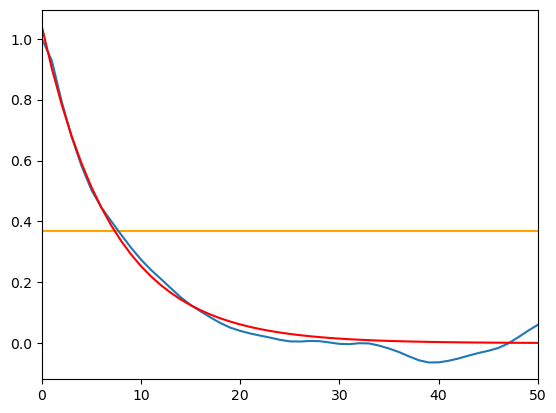

In [68]:
# Define the model function
def model_func(x, a, k):
    return a * np.exp(-k * x)
    
def model_func_re(y, a, k):
    return -1/k * np.log(y / a)

from scipy.optimize import curve_fit

inputx = np.arange(0, 51, dtype=float)
inputy = ACF_ens_smooth[:,50]
popt, pcov = curve_fit(model_func, inputx, inputy)
# Generate points for the fitted curve
#x_fit = np.linspace(0, 5, 100)
y_fit = model_func(inputx, *popt)
efoldtime = model_func_re(1/math.e,*popt)
print(efoldtime)
# x-value for plotting

#plot series
#plt.axhline(0)
#plt.axvline(0)

#plot series
plt.axhline(1/math.e, c='orange')
plt.plot(inputy, label='Data')
plt.plot(inputx, y_fit, 'r-', label='Fitted Curve')
plt.xlim(0,50)

### Time scale estimation

In [69]:
timescale= xr.DataArray(np.full(365,fill_value=np.nan))
fiterr= xr.DataArray(np.full(365,fill_value=np.nan))

inputx = np.arange(0, 51, dtype=float)

for i in range(0, 365):
    
    # Fit the model to the data
    inputy = ACF_ens_smooth[:,i]
    popt, pcov = curve_fit(model_func, inputx, inputy)
    
    y_fit = model_func(inputx, *popt)
    
    fiterr[i] = np.sqrt(np.mean((y_fit - inputy) ** 2))
    efoldtime = model_func_re(1/math.e,*popt)
    #print('i=',i,'efoldtime',np.atleast_1d(efoldtime))
    timescale[i] = efoldtime

    

In [70]:
print(fiterr)

<xarray.DataArray (dim_0: 365)>
array([0.03323033, 0.03418261, 0.03516941, 0.03618819, 0.03723594,
       0.03830918, 0.03940409, 0.04051595, 0.04163918, 0.04276814,
       0.04389697, 0.0450194 , 0.04612857, 0.0472171 , 0.04827695,
       0.04929985, 0.0502779 , 0.05120286, 0.0520665 , 0.0528611 ,
       0.05357866, 0.05421146, 0.05475209, 0.05519383, 0.05553033,
       0.05575624, 0.05586683, 0.05585797, 0.05572694, 0.05547186,
       0.05509174, 0.05458629, 0.05395656, 0.05320457, 0.05233355,
       0.05134851, 0.05025535, 0.04906062, 0.04777201, 0.04639823,
       0.04494981, 0.04343822, 0.04187574, 0.04027592, 0.03865398,
       0.03702669, 0.03541172, 0.03382771, 0.03229456, 0.03083328,
       0.02946541, 0.02821267, 0.02709608, 0.02613447, 0.02534295,
       0.02473155, 0.02430421, 0.0240579 , 0.02398221, 0.02406043,
       0.0242709 , 0.02458918, 0.02498954, 0.02544655, 0.02593635,
       0.02643728, 0.0269308 , 0.02740127, 0.02783563, 0.02822414,
       0.02855935, 0.02883606,

# Bootstrap resampling to measure the uncertainty of ACF
## Note that this step takes a long time, so skip this step if you don't need this info.
----------------------------------------------------------------------------------------

In [71]:
yearlist= list(range(total_years))
from random import choices
# Bootstrap sampling 
bootsize=1000
#bootsize=10

ACF_ens_bootstrap = xr.DataArray(np.full((51,365,bootsize),fill_value=np.nan), dims=["lags","time","samples"], coords= coords)

for i in range(bootsize):
    print('i=',i)
    sample_years = choices(yearlist, k=total_years) 

    for days in range(0,365):
        for lags in range(51): 
        
            numerator = 0.
            denominatorA = 0.
            denominatorB = 0.
           
            for yy in sample_years:
                
                if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
                    numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])*(SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])
                    denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy]-mean_SAM_np[0,days])**2
                    denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy]-mean_SAM_np[0+lags,days])**2  
            #if math.isnan(SAM_window_noleap_np[0,days+365*yy]) != True :
            #    numerator    =  numerator   + (SAM_window_noleap_np[0,days+365*yy])*(SAM_window_noleap_np[0+lags,days+365*yy])
            #    denominatorA =  denominatorA + (SAM_window_noleap_np[0,days+365*yy])**2
            #    denominatorB =  denominatorB + (SAM_window_noleap_np[0+lags,days+365*yy])**2      
            #else:
            #    print('NAN found at days:',days,'year=',yy)
         
            ACF_ens_bootstrap[lags, days, i] = numerator/((denominatorA*denominatorB)**0.5) 


i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39
i= 40
i= 41
i= 42
i= 43
i= 44
i= 45
i= 46
i= 47
i= 48
i= 49
i= 50
i= 51
i= 52
i= 53
i= 54
i= 55
i= 56
i= 57
i= 58
i= 59
i= 60
i= 61
i= 62
i= 63
i= 64
i= 65
i= 66
i= 67
i= 68
i= 69
i= 70
i= 71
i= 72
i= 73
i= 74
i= 75
i= 76
i= 77
i= 78
i= 79
i= 80
i= 81
i= 82
i= 83
i= 84
i= 85
i= 86
i= 87
i= 88
i= 89
i= 90
i= 91
i= 92
i= 93
i= 94
i= 95
i= 96
i= 97
i= 98
i= 99
i= 100
i= 101
i= 102
i= 103
i= 104
i= 105
i= 106
i= 107
i= 108
i= 109
i= 110
i= 111
i= 112
i= 113
i= 114
i= 115
i= 116
i= 117
i= 118
i= 119
i= 120
i= 121
i= 122
i= 123
i= 124
i= 125
i= 126
i= 127
i= 128
i= 129
i= 130
i= 131
i= 132
i= 133
i= 134
i= 135
i= 136
i= 137
i= 138
i= 139
i= 140
i= 141
i= 142
i= 143
i= 144
i= 145
i= 146
i= 147
i= 148
i= 149
i= 150
i= 151
i= 152
i= 153
i= 154
i= 155
i= 156
i= 157
i= 1

In [72]:
ACF_ens_bootstrap_3year = xr.concat([ACF_ens_bootstrap,ACF_ens_bootstrap,ACF_ens_bootstrap],"time")

In [73]:
ACF_ens_bootstrap_smooth = gaussian_filter(ACF_ens_bootstrap_3year, sigma=18, axes=1)

In [74]:
ACF_ens_bootstrap_smooth = ACF_ens_bootstrap_smooth[:,365:365+365]

In [75]:
#Bootstraping 
timescale_bootstrap= xr.DataArray(np.full((365,bootsize),fill_value=np.nan))

stand_dev =  xr.DataArray(np.full(365,fill_value=np.nan))

inputx = np.arange(0, 51, dtype=float)


for i in range(0, 365):
    std = 0.
    for b in range(bootsize):

        # Fit the model to the data
        inputy = ACF_ens_bootstrap_smooth[:,i,b]
        popt, pcov = curve_fit(model_func, inputx, inputy)
        

        efoldtime = model_func_re(1/math.e,*popt)
        #print('i=',i,'efoldtime',np.atleast_1d(efoldtime))
        timescale_bootstrap[i,b] = efoldtime
        std = std+ (efoldtime-timescale[i])**2.
        
    stand_dev[i] = (std/bootsize)**0.5


    

In [76]:
print(stand_dev)

<xarray.DataArray (dim_0: 365)>
array([1.47039666, 1.42537559, 1.38148806, 1.338802  , 1.29736592,
       1.2572175 , 1.21837735, 1.18086054, 1.14468021, 1.10983916,
       1.07634506, 1.04419206, 1.01338522, 0.9839295 , 0.9558464 ,
       0.92915345, 0.90386965, 0.88002893, 0.85766625, 0.83682315,
       0.81755038, 0.79990058, 0.7839236 , 0.76968532, 0.75723634,
       0.74662337, 0.73788735, 0.73105244, 0.72612491, 0.72309757,
       0.72194712, 0.72262702, 0.72506545, 0.72917542, 0.73485299,
       0.74197428, 0.75040288, 0.75999818, 0.77061307, 0.78209586,
       0.79429868, 0.80706969, 0.82026611, 0.83375973, 0.84742494,
       0.86115201, 0.87483991, 0.88840547, 0.90178136, 0.91491298,
       0.92775689, 0.94028378, 0.95247863, 0.96433138, 0.97584687,
       0.98702907, 0.99788885, 1.008431  , 1.01866003, 1.02856912,
       1.0381456 , 1.04736537, 1.05619281, 1.06457167, 1.07243114,
       1.07969067, 1.08626214, 1.09205551, 1.09697565, 1.10093023,
       1.10383675, 1.10561694,

10.838023443073432


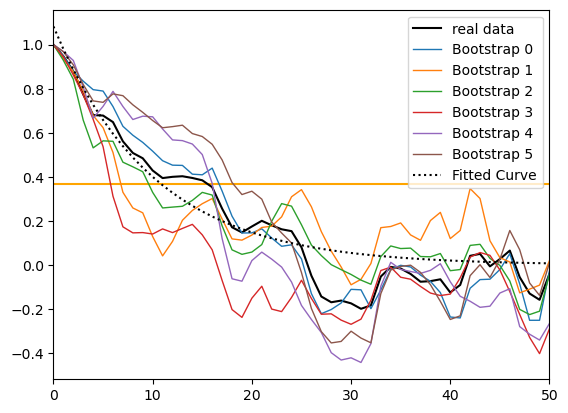

In [77]:
# Define the model function
def model_func(x, a, k):
    return a * np.exp(-k * x)
    
def model_func_re(y, a, k):
    return -1/k * np.log(y / a)

from scipy.optimize import curve_fit

inputx = np.arange(0, 51, dtype=float)
inputy = ACF_ens[:,20]
popt, pcov = curve_fit(model_func, inputx, inputy)
# Generate points for the fitted curve
#x_fit = np.linspace(0, 5, 100)
y_fit = model_func(inputx, *popt)
efoldtime = model_func_re(1/math.e,*popt)
print(efoldtime)
# x-value for plotting

#plot series
#plt.axhline(0)
#plt.axvline(0)

#plot series
plt.axhline(1/math.e, c='orange')
plt.plot(inputy, 'k', label='real data')
plt.plot(ACF_ens_bootstrap[:,20,0], lw=1, label='Bootstrap 0')
plt.plot(ACF_ens_bootstrap[:,20,1], lw=1,label='Bootstrap 1')
plt.plot(ACF_ens_bootstrap[:,20,2], lw=1,label='Bootstrap 2')
plt.plot(ACF_ens_bootstrap[:,20,3], lw=1,label='Bootstrap 3')
plt.plot(ACF_ens_bootstrap[:,20,4], lw=1, label='Bootstrap 4')
plt.plot(ACF_ens_bootstrap[:,20,5], lw=1, label='Bootstrap 5')
plt.plot(inputx, y_fit, 'k:', label='Fitted Curve')
plt.xlim(0,50)
plt.legend()

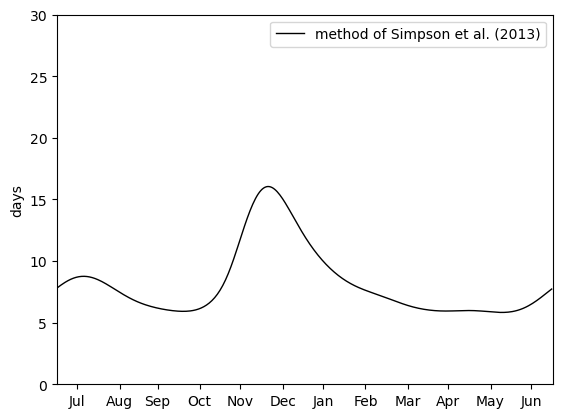

In [78]:
shifted_timescale = np.roll(timescale, -181, axis=0)
shifted_std = np.roll(stand_dev, -181, axis=0)
#shifted_fiterror = np.roll(fiterr, -181, axis=0)

#shifted_timescale_bootstrap = np.roll(timescale_bootstrap, -181, axis=0)
#shifted_timescale_bootstrap_min = np.min(shifted_timescale_bootstrap, axis=1)
#shifted_timescale_bootstrap_max = np.max(shifted_timescale_bootstrap, axis=1)

days=np.arange(0, 365, 1)
plt.plot(days, shifted_timescale,'k',linewidth=1, label='method of Simpson et al. (2013)')

#plt.plot(days, shifted_timescale_bootstrap[:,0],linewidth=1)
#plt.plot(days, shifted_timescale_bootstrap[:,5],linewidth=1)
#plt.plot(days, shifted_timescale_bootstrap[:,30],linewidth=1)
#plt.errorbar(days, shifted_timescale, yerr=shifted_fiterror)
#plt.fill_between(days, shifted_timescale-1*shifted_std, shifted_timescale+1*shifted_std,alpha=0.5)

plt.xticks([15, 31+15, 59+15,90+15,120+15,151+15, 181+15,212+15,243+15,273+15,304+15,334+15], ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb', 'Mar','Apr','May','Jun'])
#       rotation=40)  # Set text labels and properties.
plt.ylabel('days')
plt.ylim(0,30)
plt.xlim(0,365)
plt.legend()
#plt.savefig('SAMtimescale_ERA5_2std_bootstrap1000_1940to1978', bbox_inches='tight', dpi=100)
plt.show()

In [79]:
EXPname='ERA5_1958_1978'
#EXPname='ERA5_1980_2014'
np.savetxt(EXPname+'_Jul2Jun_timescale.out', shifted_timescale, delimiter=',')
np.savetxt(EXPname+'_Jul2Jun_std_bootstraptime1000.out', shifted_std, delimiter=',')
#np.savetxt(EXPname+'_Jul2Jun_timescaleMIN_bootstraptime1000.out', shifted_timescale_bootstrap_min, delimiter=',')
#np.savetxt(EXPname+'_Jul2Jun_timescaleMAX_bootstraptime1000.out', shifted_timescale_bootstrap_max, delimiter=',')

----------------------------------------------------------------------------------------

In [84]:
#####################
# save the SAM index
#####################
coords= {"time":daily_value["geop"].coords['time'],}


SAMindex = xr.DataArray(
    data=pc1_ar,
    dims=["time"],
    coords= coords,
    name="SAMindex",
)


In [85]:
SAMindex

<xarray.DataArray 'SAMindex' (time: 16071)>
array([0.74962582, 0.79176988, 0.56287688, ..., 1.13137111, 0.99593561,
       0.87652998])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-31

In [87]:
#####################
# save the SAM eof (multiplied by the normalization factor used in PC1)
#####################
coords= {"lat":z.coords['lat'],}


SAMeof = xr.DataArray(
    data=eof1_rescaled[0,:]*-1,
    dims=["lat"],
    coords= coords,
    name="EOF1",
)


In [88]:
#outputFileName = 'ERA5_1980_2014_SAMindex.nc'
outputFileName = EXPname+'_SAMindex.nc'

print ('saving to ', outputFileName)
SAMindex.to_netcdf(path=outputFileName)
SAMindex.close()
print ('finished saving 1')

saving to  ERA5_1958_1978_SAMindex.nc
finished saving 1


In [89]:
#outputFileName2 = 'ERA5_1980_2014_SAMeof.nc'
outputFileName2 = EXPname+'_SAMeof.nc'

print ('saving to ', outputFileName2)
SAMeof.to_netcdf(path=outputFileName2)
SAMeof.close()
print ('finished saving 2')

saving to  ERA5_1958_1978_SAMeof.nc
finished saving 2


### Examining the profile of annual-mean ACF

In [80]:
ACF_annual = ACF_ens.mean("time")
ACF_annual_smooth = np.nanmean(ACF_ens_smooth, axis=1)

In [81]:
ACF_annual

<xarray.DataArray (lags: 51)>
array([1.        , 0.93537033, 0.8103081 , 0.69619073, 0.59963837,
       0.51714823, 0.44997038, 0.39492523, 0.34721855, 0.30523299,
       0.26998771, 0.2406083 , 0.21361199, 0.18846117, 0.16736681,
       0.15091504, 0.13690626, 0.12197645, 0.10525758, 0.08902531,
       0.07533639, 0.06504836, 0.05826401, 0.05336344, 0.04845173,
       0.04406882, 0.04087814, 0.03890876, 0.03673964, 0.03351713,
       0.03020166, 0.02818327, 0.02747975, 0.02593466, 0.02318815,
       0.02008633, 0.01575153, 0.01031573, 0.00571176, 0.00335293,
       0.00328744, 0.00524231, 0.00910927, 0.01477515, 0.02199771,
       0.03067097, 0.04036202, 0.04957771, 0.0582544 , 0.06588408,
       0.07108216])
Dimensions without coordinates: lags

7.845776323748479


(0.0, 50.0)

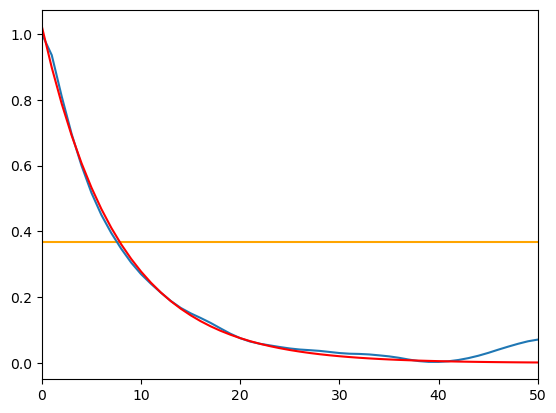

In [82]:
# Define the model function
def model_func(x, a, k):
    return a * np.exp(-k * x)
    
def model_func_re(y, a, k):
    return -1/k * np.log(y / a)

from scipy.optimize import curve_fit

inputx = np.arange(0, 51, dtype=float)
inputy = ACF_annual
popt, pcov = curve_fit(model_func, inputx, inputy)
# Generate points for the fitted curve
#x_fit = np.linspace(0, 5, 100)
y_fit = model_func(inputx, *popt)
efoldtime = model_func_re(1/math.e,*popt)
print(efoldtime)
# x-value for plotting

#plot series
#plt.axhline(0)
#plt.axvline(0)

#plot series
plt.axhline(1/math.e, c='orange')
plt.plot(inputy, label='Data')
plt.plot(inputx, y_fit, 'r-', label='Fitted Curve')
plt.xlim(0,50)

### Figure 1 for the paper 

16071
8.679194723580762
0.36787944117144233


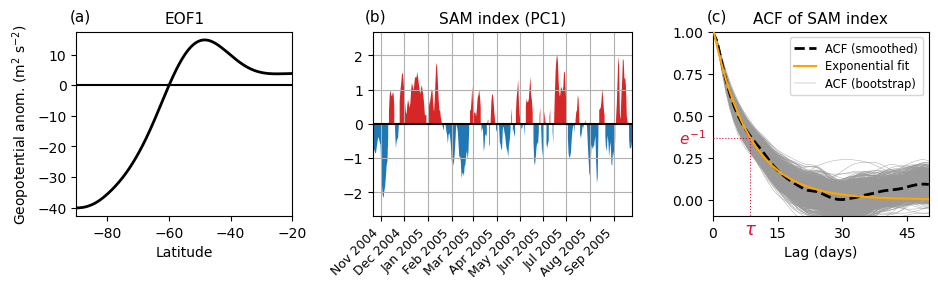

In [156]:
x1= 22260-13200
x2= 22600-13200
data = SAMindex.isel(time=slice(x1, x2))  # Subset your data

# Ensure 'time' is in datetime64 format
data["time"] = pd.to_datetime(data["time"].values)  # Convert to datetime64

# Extract the first day of each month for tick positions
monthly_ticks = data.time.where(data.time.dt.day == 1, drop=True)

fig = plt.figure(figsize=(11,2.4))
gs = fig.add_gridspec(1, 3,  width_ratios=(1, 1.2, 1))
#----------------------------------------
ax = fig.add_subplot(gs[0])

plt.plot(z.coords['lat'].values, eof1_rescaled[0,:]*-1,color='k', linewidth=2)
ax.axhline(0, color='k')
ax.set_xlim(-90, -20)
ax.set_yticks(np.arange(-40,12,10))
#ax.set_yticklabels(np.arange(-40,12,10))
ax.set_xlabel('Latitude')
ax.set_ylabel('Geopotential anom. ' r'$(\mathrm{m}^{2}$'' 'r'$\mathrm{s}^{-2})$')
ax.set_title('EOF1', fontsize=11)
plt.text(-0.03, 1.12, '(a)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)
#----------------------------------------
ax = fig.add_subplot(gs[1])

#plt.plot(pc1[:, 0],color='b', linewidth=1,label='raw data')
ax = plt.gca()
ax.axhline(0, color='k')
#ax.set_xlim(10000,10000+370)
#ax.set_xticks(dateseris[1000])
#ax.set_xticklabels(np.arange(0,370,60))
ax.set_ylim(-2.7,2.7)
#ax.set_xlabel('Days from 01-01-2022')
#ax.set_ylabel('Normalized Units')
ax.set_title('SAM index (PC1)', fontsize=11)
nt_test=pc1[:,0].shape[0]
print(nt_test)
x_test= np.arange(nt_test)
ax.fill_between(data['time'], pc1_rescaled[x1:x2, 0], y2=0, where=pc1[x1:x2,0] > 0, facecolor='tab:red')
ax.fill_between(data['time'], pc1_rescaled[x1:x2, 0], y2=0, where=pc1[x1:x2,0] < 0, facecolor='tab:blue')

# Set x-axis ticks and labels
ax.set_xticks(monthly_ticks.values)
ax.set_xticklabels(monthly_ticks.dt.strftime("%b %Y").values, rotation=45, ha="right",fontsize=9)

ax.set_xlim(data['time'].isel(time=0),data['time'].isel(time=(x2-x1-1)))
# Gaussian filtering of time series data
#smoothed42_pc1= filters.convolve1d(pc1[:, 0], b / b.sum())

#smoothed60_pc1 = gaussian_filter(pc1, sigma=26)
#smoothed42_pc1 = gaussian_filter(pc1, sigma=18)
#smoothed12_pc1 = gaussian_filter(pc1, sigma=5)
#plt.plot(smoothed60_pc1[:, 0],color='r', linewidth=1.5, label='FWHM:60 d (''$\sigma$:26 d)')
#plt.plot(smoothed42_pc1,color='g', linewidth=1.5, label='FWHM:42 d (''$\sigma$:18 d)')
#plt.plot(smoothed12_pc1[:, 0],color='orange', linewidth=1.5, label='FWHM:12 d (''$\sigma$:5 d)')
ax.grid()
#plt.legend(ncol=4)
plt.text(-0.03, 1.12, '(b)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)


#----------------------------------------
ax = fig.add_subplot(gs[2])

dd = 195
inputx = np.arange(0, 51, dtype=float)
inputy = ACF_ens_smooth[:,dd]
popt, pcov = curve_fit(model_func, inputx, inputy)
# Generate points for the fitted curve
#x_fit = np.linspace(0, 5, 100)
y_fit = model_func(inputx, *popt)
efoldtime = model_func_re(1/math.e,*popt)
print(efoldtime)
# x-value for plotting

#plot series
#plt.axhline(0)
#plt.axvline(0)

#plot series
plt.plot(inputy, 'k', linestyle='dashed',lw=2, label='ACF (smoothed)', zorder=2000)
plt.plot(inputx, y_fit, 'orange', linestyle='solid', lw=1.5, label='Exponential fit', zorder=2000)
print(1/math.e)
plt.hlines(1/math.e, xmin=0, xmax=efoldtime, colors='crimson',lw=0.8,linestyle='dotted', zorder=2000)
plt.vlines(efoldtime, ymin=-0.2, ymax=1/math.e, colors='crimson',linestyle='dotted',lw=0.8,zorder=4000)
ax.set_xlabel('Lag (days)')
#ax.set_ylabel('Autocorrelation')
for ens in range(1000):
    plt.plot(ACF_ens_bootstrap_smooth[:,dd,ens], lw=0.3, color='0.6')
plt.plot(ACF_ens_bootstrap_smooth[:,dd,0], lw=0.3, color='0.6', label='ACF (bootstrap)')

#plt.plot(ACF_ens_bootstrap_smooth[:,50,50], lw=0.6, color='0.5', label='ACF (bootstrap n)')
plt.xlim(0,50)
plt.text(efoldtime,-0.18, r'$\tau$',va='center', ha='center', color='crimson', fontsize=13)
plt.text(-7.9,1/math.e,r'$e^{-1}$',va='center',color='crimson', fontsize=11)
plt.legend(labelspacing=0.4, handlelength=1.9, fontsize='small')
plt.ylim(-0.1,1)
ax.set_title('ACF of SAM index', fontsize=11)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_xticks([0,15,30,45])

plt.text(-0.03, 1.12, '(c)', fontsize=11,
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax.transAxes)

plt.subplots_adjust(wspace=0.35)
plt.savefig('Fig1_ERA5_SAMdecorrelation_example_1980-2023_dd_'+str(dd), bbox_inches='tight', dpi=200)



plt.show()